# SC3000 Assignment 1: Pole Balancing
## Done by:
1. Luar Shui Yan (U2221566E)
2. Tan Yong Jie (U2222722B)

## Contributions:
1. Luar Shui Yan
- Researched PPO, DQN and various other RL models
- Implemented and tested PPO on the problem statement
- Made evaluation and conclusion on the problem

2. Tan Yong Jie
- Tested viability of DQN on the Cartpole problem
- Tested and debugged model training codes
- Made evaluative feedback on the problem

## Problem Statement Summary


### Problem Statement
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, we will develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.


### Action Space
The action is an *ndarray* with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.


### State Space
We define *observation* as a state (they are used interchangeably here). The observation is an *ndarray* with shape (4,) with the values corresponding to the following positions and velocities:

| **Observation[n]** | **Observation**       | **Min**             | **Max**           |
| ------- | --------------------- | ------------------- | ----------------- |
| **0**   | Cart Position         | \-4.8               | 4.8               |
| **1**   | Cart Velocity         | \-Inf               | Inf               |
| **2**   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| **3**   | Pole Angular Velocity | \-Inf               | Inf               |

## Objective

Balance the pole for at least 500 states per episode.

The pole is said to be balanced if:
* -12° <= Pole Angle <= 12°
* Cart Position <= ±2.4 (center of the cart reaches the edge of the display)

Violation to any of the two conditions results in an unbalanced pole.

## Solution

We did research on the following RL methods:

1. Proximal Policy Optimization (PPO)

Pros:

- Stable and reliable performance.
- Efficient data use.


Cons:

- Relatively complex implementation.
- Requires careful tuning.



2. Deep Q-Network (DQN)

Pros:

- Simple and intuitive.
- Good for discrete action spaces.

Cons:

- Struggles with continuous spaces.
- Sample efficiency can be low.


3. Soft Actor-Critic (SAC)

Pros:

- Handles continuous action spaces well.
- High sample efficiency.

Cons:

- More complex than DQN.
- Requires careful hyperparameter tuning.

4. Trust Region Policy Optimization (TRPO)

Pros:

- Stable learning updates.
- Good for complex control tasks.

Cons:

- Computationally expensive.
- Implementation is non-trivial.





Below are the articles we referred to for research

Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2022). Proximal Policy Optimization (PPO) Explained. Towards Data Science. Retrieved from https://towardsdatascience.com/proximal-policy-optimization-ppo-explained-abed1952457b

M. Gupta. (2023). Deep Q-Networks (DQN) Explained with Examples and Codes in Reinforcement Learning. Medium. Retrieved from https://medium.com/data-science-in-your-pocket/deep-q-networks-dqn-explained-with-examples-and-codes-in-reinforcement-learning-928b97efa792

V.V. Kumar. (2019). Soft Actor-Critic Demystified. Towards Data Science. Retrieved from https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665

J. SChulman. (2017). Trust Region Policy Optimization. Papers with Code. Retrieved from https://paperswithcode.com/method/trpo#:~:text=Trust%20Region%20Policy%20Optimization%2C%20or,policy%20update%20at%20each%20iteration.



### Rationale

After considering various factors, we will be using **Proximal Policy Optimization (PPO)** over the other three RL methods. This is because:

1. PPO efficiently balances exploration and exploitation, ideal for dynamic environments.
2. DQN struggles with continuous action spaces; cartpole requires fine control.
3. SAC is overly complex for a relatively simple and well-defined problem.
4. TRPO is too computationally intensive for tasks that demand quick adaptations.

## Import Dependencies

Stable Baselines is a set of improved implementations of Reinforcement Learning (RL) algorithms based on OpenAI Baselines. We will be importing the PPO algorithm from here.

* Reference & more details: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
* Implementation code of PPO in stable-baseline3: https://github.com/DLR-RM/stable-baselines3/tree/master/stable_baselines3/ppo

In [1]:
!pip install gym
!pip install stable_baselines3
!pip install torch
!pip install shimmy
!pip install moviepy
!pip install pygame

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import torch
import glob


## Environment Setup

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

## Model Training

Check if CUDA device is available.

In [4]:
torch.cuda.is_available()
print(torch.version.cuda)

None


### Vectorized Environment

Vectorized Environments are a method for stacking multiple independent environments into a single environment.

This provides two benefits:

* Agent experience can be collected more quickly
* The experience will contain a more diverse range of states, it usually improves exploration

Stable-Baselines provides two types of Vectorized Environment:

* SubprocVecEnv which run each environment in a separate process
* DummyVecEnv which run all environment on the same process
In practice, DummyVecEnv is usually faster than SubprocVecEnv because of communication delays that subprocesses have.

In [5]:
env = gym.make(env_name)
env = DummyVecEnv([lambda: env])

# model = PPO('MlpPolicy', env, verbose=1, device="cuda") # run this if you have an Nvidia GPU installed
model = PPO('MlpPolicy', env, verbose=1, device="auto")   # otherwise run this instead

Using cpu device


C:\Users\Yong Jie\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### Training the model

We will begin training the model using a timestep of 30000 actions

* total_timesteps: int; i.e. the total number of samples to train on

* Addendum: total_timesteps represents a singular interaction cycle within the environment, where an agent performs an action and subsequently receives both a new observation and a reward from the environment. Each cycle, the agent picks an action derived from its current strategy, which the environment processes to produce the next state and reward. This feedback loop aids in refining the agent's policy parameters over time.

In [6]:
# total_timesteps is the number of env.steps(action) being run during training
model = model.learn(total_timesteps = 30000)

-----------------------------
| time/              |      |
|    fps             | 2379 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1588        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009067798 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.000208   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.64        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 46.7        |
-----------------------------------------
----------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 1255       |
|    iterations           | 13         |
|    time_elapsed         | 21         |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.00287063 |
|    clip_fraction        | 0.0175     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.519     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.31       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.00182   |
|    value_loss           | 23.4       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1251         |
|    iterations           | 14           |
|    time_elapsed         | 22           |
|    total_timesteps      | 28672        |
| tr

## Task 1 (Model Testing)

In [7]:
observation = env.reset()
action, _ = model.predict(observation)
print("Observation space is: ", observation)
print("Action taken is: ", action)

Observation space is:  [[ 0.04748403 -0.01590968 -0.00822803 -0.01000173]]
Action taken is:  [1]


## Task 2 (Average Score)

* We ran the trained agent for 100 episodes, and we displayed the score that the agent received for each episode

* Then, we calculated the average score of that the agent received for the 100 episodes

In [8]:
sum_episode_scores = []

for episode in range(1, 100):    ## total 10 episodes
    score = 0                   ## reward init
    obs = env.reset()         ## observations
    done = False                ## episode completes will make done True
    state = 0

    while True:
        action = model.predict(obs)[0]
        n_state, reward, done, info = env.step(action)      ## apply action
        if (abs(n_state[0][0]) > 2.4 or abs(n_state[0][2]) > 0.209):
            break
        if state == 500:
            break
        obs = n_state
        score += reward
        state += 1

    print('Episode:', episode, ';   Score:', score)
    sum_episode_scores.append(score)


print("Average score is ", sum(sum_episode_scores) / len(sum_episode_scores))

env.close()

Episode: 1 ;   Score: [500.]
Episode: 2 ;   Score: [500.]
Episode: 3 ;   Score: [500.]
Episode: 4 ;   Score: [500.]
Episode: 5 ;   Score: [500.]
Episode: 6 ;   Score: [500.]
Episode: 7 ;   Score: [500.]
Episode: 8 ;   Score: [500.]
Episode: 9 ;   Score: [500.]
Episode: 10 ;   Score: [500.]
Episode: 11 ;   Score: [500.]
Episode: 12 ;   Score: [500.]
Episode: 13 ;   Score: [500.]
Episode: 14 ;   Score: [500.]
Episode: 15 ;   Score: [500.]
Episode: 16 ;   Score: [500.]
Episode: 17 ;   Score: [500.]
Episode: 18 ;   Score: [500.]
Episode: 19 ;   Score: [500.]
Episode: 20 ;   Score: [500.]
Episode: 21 ;   Score: [500.]
Episode: 22 ;   Score: [500.]
Episode: 23 ;   Score: [500.]
Episode: 24 ;   Score: [500.]
Episode: 25 ;   Score: [500.]
Episode: 26 ;   Score: [500.]
Episode: 27 ;   Score: [500.]
Episode: 28 ;   Score: [500.]
Episode: 29 ;   Score: [500.]
Episode: 30 ;   Score: [500.]
Episode: 31 ;   Score: [500.]
Episode: 32 ;   Score: [500.]
Episode: 33 ;   Score: [500.]
Episode: 34 ;   Sco

* We then plotted the score of each episode onto a graph and from the graph, we can see that our trained agent performs well on each of the 100 episodes, with only a few outliers.

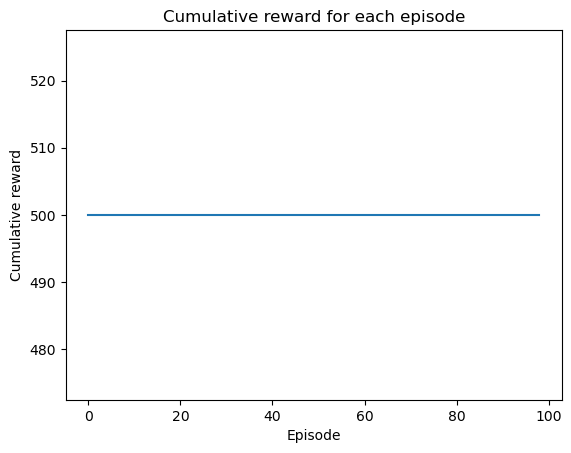

In [9]:
#plt.plot([1,2,3,4])
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()

## Task 3 (1 Episode)

* Task 3 requires us to render one of the episodes played by our PPO agent

In [10]:
from gym.wrappers import RecordVideo
from IPython.display import HTML, Video
from IPython import display as ipythondisplay
import io
import base64
import os

def show_video():
    ipythondisplay.clear_output(wait=True)
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [11]:
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='human')
env = RecordVideo(env, './video')

observation = env.reset()[0]
total_reward = 0
for _ in range(500):  # Loop for a maximum of 500 steps
    action = model.predict(observation)[0]  
    print(env.step(action))
    observation, reward, done, info, _ = env.step(action)
    total_reward += reward
    if done:
        break

env.close()
show_video()

Could not find video


In [12]:
print("Episode reward is ", total_reward)

Episode reward is  434.0


## Further Investigation

Let us examine how good PPO is in terms of total timesteps taken to train in order to achieve a relatively good average score.

In [13]:
avg_score_per_dif_timesteps = []
env_name = 'CartPole-v1'
env = gym.make(env_name)

for i in range(5000, 35000, 5000):
    print(f"Training model for {i} timesteps started")
    model = PPO('MlpPolicy', env, verbose=1, device="cuda")
    model.learn(total_timesteps=i, progress_bar=False)
    print(f"Training model for {i} timesteps completed")

    sum_episode_scores = []
    for episode in range(1, 101):  # Running 100 episodes
        score = 0
        obs = env.reset()[0]
        done = False
        while not done and score < 500:
            action = model.predict(obs)[0]
            obs, reward, done, info, _ = env.step(action)
            score += reward
        sum_episode_scores.append(score)

    avg = sum(sum_episode_scores) / len(sum_episode_scores)
    print(f"Average score for {i} timesteps is {round(avg, 2)}")
    avg_score_per_dif_timesteps.append(round(avg, 2))

env.close()

C:\Users\Yong Jie\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Training model for 5000 timesteps started
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.1     |
|    ep_rew_mean     | 25.1     |
| time/              |          |
|    fps             | 2325     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 28.5       |
|    ep_rew_mean          | 28.5       |
| time/                   |            |
|    fps                  | 1639       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00845978 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.5         |
|    ep_rew_mean          | 49.5         |
| time/                   |              |
|    fps                  | 1401         |
|    iterations           | 4            |
|    time_elapsed         | 5            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0077446913 |
|    clip_fraction        | 0.0683       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.642       |
|    explained_variance   | 0.196        |
|    learning_rate        | 0.0003       |
|    loss                 | 21           |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0164      |
|    value_loss           | 55           |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 76.4       |
|    ep_rew_mean          | 76.4       |
| time/                   |            |
|    fps                  | 1255       |
|    iterations           | 6          |
|    time_elapsed         | 9          |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.00553773 |
|    clip_fraction        | 0.046      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.584     |
|    explained_variance   | 0.361      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.2       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 69.8       |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93.4         |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 76          |
|    ep_rew_mean          | 76          |
| time/                   |             |
|    fps                  | 1274        |
|    iterations           | 6           |
|    time_elapsed         | 9           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.005403164 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.596      |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.6        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 63.8        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 91  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34.8        |
|    ep_rew_mean          | 34.8        |
| time/                   |             |
|    fps                  | 1422        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.009867414 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.666      |
|    explained_variance   | 0.107       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 35.5        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48.1  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 203         |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 1240        |
|    iterations           | 13          |
|    time_elapsed         | 21          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.011229124 |
|    clip_fraction        | 0.0687      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.56       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.34        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00993    |
|    value_loss           | 4.84        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 220 

In [14]:
print(avg_score_per_dif_timesteps)

[70.35, 143.24, 303.98, 391.1, 450.51, 490.18]


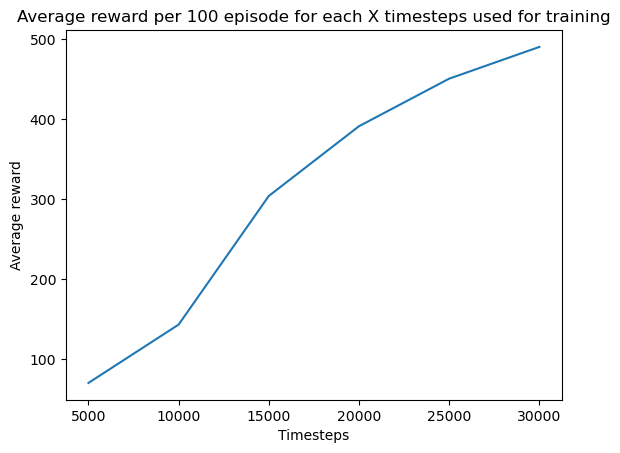

In [15]:
plt.plot(avg_score_per_dif_timesteps)
x_labels = ['5000', '10000', '15000', '20000', '25000', '30000']
plt.title("Average reward per 100 episode for each X timesteps used for training")
plt.ylabel("Average reward")
plt.xlabel("Timesteps")
plt.xticks(range(len(x_labels)), x_labels)
plt.show()

As the graph shown, PPO is able to get an acceptable average scores of above 300 with only 15000 timesteps
At 25000 timesteps, PPO is able to achieve perfect score.

## Appendix: (Attempted) Deep Q-learning

In this section we will show our attempt with DQN.



The following sources guided and helped us in the implementation of DQN, and taught us a lot, despite not settling with DQN ultimately.

Schwarz, L. (2021). Explanation and Implementation of DQN with Tensorflow and Keras. Retrieved from lukasschwarz.de

FreeCodeCamp. (n.d.). Improvements in Deep Q Learning: Dueling Double DQN, Prioritized Experience Replay, and fixed…. Retrieved from freecodecamp.org

PyTorch. (n.d.). Reinforcement Learning (DQN) Tutorial — PyTorch Tutorials 2.2.1+cu121 documentation. Retrieved from pytorch.org

Hugging Face. (n.d.). Deep Q-Learning with Space Invaders. Retrieved from huggingface.co

Towards Data Science. (n.d.). Welcome to Deep Reinforcement Learning Part 1: DQN. Retrieved from towardsdatascience.com


In [16]:
import gym
import numpy as np

environment = gym.make("CartPole-v1")

learning_rate = 0.2
discount = 1
episodes = 30000
observation_space = [40, 40, 50, 50]
window_size = np.array([0.25, 0.25, 0.05, 0.5])
exploration_rate = 1
exploration_rate_minimum = 0.05
exploration_decay = (exploration_rate - exploration_rate_minimum) / 12500
rewards_history = []

observation = environment.reset()

q_table = np.zeros((observation_space + [environment.action_space.n]))

def calculate_discrete_state(state):
    discrete_state = state / window_size + np.array([15, 10, 1, 10])
    return tuple(discrete_state.astype(int))

In [ ]:
def train(environment, total_episodes, rate, discount_factor, exploration, decay_rate, strategy_table):
    accumulated_reward = 0
    previous_average_reward = 0
    for ep in range(total_episodes):
        state_index = calculate_discrete_state(environment.reset()[0])
        finished = False
        ep_reward = 0
        steps = 0
        if ep % 2000 == 0:
            print("Episode: " + str(ep))
        while not finished:
            if np.random.random() > exploration:
                action_decision = np.argmax(strategy_table[state_index])
            else:
                action_decision = np.random.randint(0, environment.action_space.n)
            new_state_info = environment.step(action_decision)
            new_state = new_state_info[0]
            reward = new_state_info[1]
            finished = new_state_info[2]
            ep_reward += reward
            steps += 1
            new_state_index = calculate_discrete_state(new_state)
            future_max_q = np.max(strategy_table[new_state_index])
            current_q_value = strategy_table[state_index + (action_decision,)]
            reward = 1 if finished and steps >= 195 else -1 if finished else 0.1

            updated_q = (1 - rate) * current_q_value + rate * (reward + discount_factor * future_max_q)
            strategy_table[state_index + (action_decision,)] = updated_q

            state_index = new_state_index
        accumulated_reward += ep_reward
        rewards_history.append(ep_reward)

        if exploration > 0.05 and ep_reward > previous_average_reward:
            exploration -= decay_rate
        if ep % 1000 == 0:
            print("Exploration Rate: " + str(exploration))
            average_ep_reward = accumulated_reward / 1000
            print("Average Episode Reward: " + str(average_ep_reward))
            previous_average_reward = average_ep_reward
            accumulated_reward = 0
            
    environment.close()
    return strategy_table, rewards_history

strategy_table, episode_rewards = train(environment, episodes, learning_rate, discount, exploration_rate, exploration_decay, q_table)


Episode: 0
Exploration Rate: 0.999924
Average Episode Reward: 0.016
Exploration Rate: 0.923924000000035
Average Episode Reward: 23.513
Episode: 2000
Exploration Rate: 0.8885080000000514
Average Episode Reward: 26.462
Exploration Rate: 0.8569680000000659
Average Episode Reward: 28.2
Episode: 4000
Exploration Rate: 0.8248960000000807
Average Episode Reward: 30.773
Exploration Rate: 0.7912280000000962
Average Episode Reward: 33.596
Episode: 6000
Exploration Rate: 0.7607520000001102
Average Episode Reward: 35.616
Exploration Rate: 0.7251080000001267
Average Episode Reward: 39.939
Episode: 8000
Exploration Rate: 0.6903760000001427
Average Episode Reward: 43.698
Exploration Rate: 0.6540480000001594
Average Episode Reward: 47.63
Episode: 10000
Exploration Rate: 0.6161240000001769
Average Episode Reward: 53.254
Exploration Rate: 0.5823800000001924
Average Episode Reward: 54.811
Episode: 12000
Exploration Rate: 0.5444560000002099
Average Episode Reward: 60.216
Exploration Rate: 0.50622800000022

In [ ]:
observation = environment.reset()
print("Observation:", observation[0])
discrete_state = calculate_discrete_state(observation[0])
action = np.argmax(q_table[discrete_state])
print("Chosen Action:", action)

In [ ]:
accumulated_rewards = []

for ep in range(100):
    state_index = calculate_discrete_state(environment.reset()[0])
    finished = False
    ep_reward = 0
    while not finished:
        action_decision = np.argmax(strategy_table[state_index])
        new_state_info = environment.step(action_decision)
        new_state = new_state_info[0]
        reward = new_state_info[1]
        finished = new_state_info[2]
        ep_reward += reward
        if ep_reward > 500:
            finished = True
        new_state_index = calculate_discrete_state(new_state)
        state_index = new_state_index
        if finished:
            observation = environment.reset()
            state_index = calculate_discrete_state(observation[0])
    accumulated_rewards.append(ep_reward)
environment.close()


In [ ]:
print(accumulated_rewards)

In [ ]:
plt.plot(accumulated_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

plt.show()

In conclusion, PPO is more feasible to solve CartPole-v1 due to several factors:
1. Continuous Action Space:

The continuous action space of Cartpole implies endless range of potential actions, and DQN in particular struggles in such a setting.

2. Sample Efficiency:

PPO can give us our desired results in fewer training episodes than other RL methods, most notably DQN

3. Training Duration:

Cartpole has a continuous action space and RL methods like DQN are forced to discretise it first, degrading its performance compared to PPO